In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import mlflow
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature

from sd_vae.ae import VAE
from trainers import EarlyStopping
from trainers.first_stage_trainer import CLEAR_VAEFirstStageTrainer

from modules.loss import SupCon

import data_utils.styled_mnist.corruptions as corruptions
from data_utils.styled_mnist.data_utils import StyledMNISTGenerator, StyledMNIST

%load_ext autoreload
%autoreload 2

In [2]:
mnist = MNIST("./data", train=True, download=False)

In [3]:
generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)
dataset = StyledMNIST(
    generator, 
    transforms.Compose([
        transforms.ToTensor(), 
        lambda img: img / 255.0,
    ])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])

Generating dataset: 100%|██████████| 60000/60000 [00:14<00:00, 4074.93item/s]


In [4]:
train_loader = DataLoader(train, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

In [52]:
params = {
    "lr": 5e-4,
    "optimizer": "Adam",
    "batch_size": 512,
    "beta": 1/8,
    "gamma": 100,
}

input_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
output_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

vae = VAE(
    channels=32,
    channel_multipliers=[1, 2, 4],
    n_resnet_blocks=1,
    x_channels=1,
    z_channels=2,
    norm_channels=32,
    n_heads=4,
).cuda()

trainer = CLEAR_VAEFirstStageTrainer(
    contrastive_criterion=SupCon(temperature=0.2),
    model=vae,
    optimizer=torch.optim.Adam(vae.parameters(), lr=params["lr"]),
    early_stopping=EarlyStopping(patience=8),
    verbose_period=2,
    device="cuda",
    model_signature=signature,
    hyperparams={"beta": params["beta"], "gamma": params["gamma"]},
)

In [53]:
mlflow.set_tracking_uri("./mlruns")
mlflow.set_experiment("test")
with mlflow.start_run():
    mlflow.log_params(params)
    trainer.fit(epochs=51, train_loader=train_loader, valid_loader=valid_loader)

100%|██████████| 79/79 [00:01<00:00, 72.66batch/s]


epoch 0/val_rec: 64.1808
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 71.67batch/s]


epoch 2/val_rec: 28.4466
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 71.83batch/s]


epoch 4/val_rec: 23.8386
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 71.29batch/s]


epoch 6/val_rec: 22.1805
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 71.90batch/s]


epoch 8/val_rec: 18.2884
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 71.25batch/s]


epoch 10/val_rec: 16.0890
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 71.68batch/s]


epoch 12/val_rec: 15.1067
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 69.92batch/s]


epoch 14/val_rec: 15.0348


100%|██████████| 79/79 [00:01<00:00, 69.69batch/s]


epoch 16/val_rec: 14.2010


100%|██████████| 79/79 [00:01<00:00, 71.90batch/s]


epoch 18/val_rec: 13.0643
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 70.57batch/s]


epoch 20/val_rec: 13.9907


100%|██████████| 79/79 [00:01<00:00, 71.02batch/s]


epoch 22/val_rec: 11.9021
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 70.30batch/s]


epoch 24/val_rec: 11.8083


100%|██████████| 79/79 [00:01<00:00, 70.23batch/s]


epoch 26/val_rec: 11.5591


100%|██████████| 79/79 [00:01<00:00, 69.69batch/s]


epoch 28/val_rec: 11.2245
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 41.27batch/s]


epoch 30/val_rec: 11.7353


100%|██████████| 79/79 [00:01<00:00, 49.72batch/s]


epoch 32/val_rec: 10.6761
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 44.18batch/s]


epoch 34/val_rec: 10.8093


100%|██████████| 79/79 [00:01<00:00, 40.56batch/s]


epoch 36/val_rec: 10.4366
[INFO]: track model state


100%|██████████| 79/79 [00:02<00:00, 37.24batch/s]


epoch 38/val_rec: 10.0818
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 44.99batch/s]


epoch 40/val_rec: 10.6058


100%|██████████| 79/79 [00:01<00:00, 70.30batch/s]


epoch 42/val_rec: 10.0793


100%|██████████| 79/79 [00:01<00:00, 70.76batch/s]


epoch 44/val_rec: 9.7241


100%|██████████| 79/79 [00:01<00:00, 69.74batch/s]


epoch 46/val_rec: 11.7627


100%|██████████| 79/79 [00:01<00:00, 71.31batch/s]


epoch 48/val_rec: 9.8007


100%|██████████| 79/79 [00:01<00:00, 69.63batch/s]


epoch 50/val_rec: 10.2838
[INFO]: log best model


In [55]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

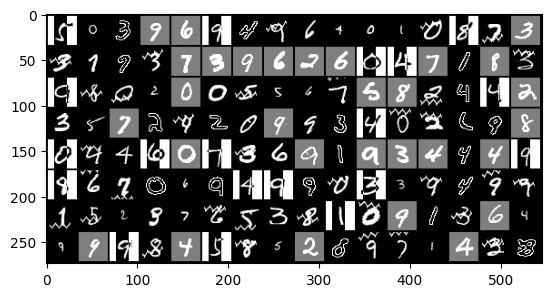

In [56]:
x = next(iter(test_loader))['image'].to("cuda")
plt.imshow(make_grid(x, nrow=16).cpu().permute(1,2,0))

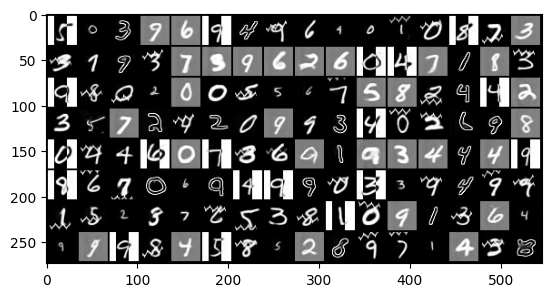

In [58]:
best_model = mlflow.pytorch.load_model('runs:/a92347e169054c17924cc0da1fde2106/best_model')
with torch.no_grad():
    best_model.eval()
    xhat, posterior = best_model(x)
    plt.imshow(make_grid(xhat, nrow=16).cpu().permute(1,2,0))

torch.Size([128, 2, 8, 8])


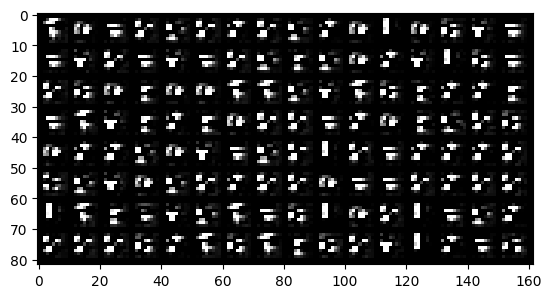

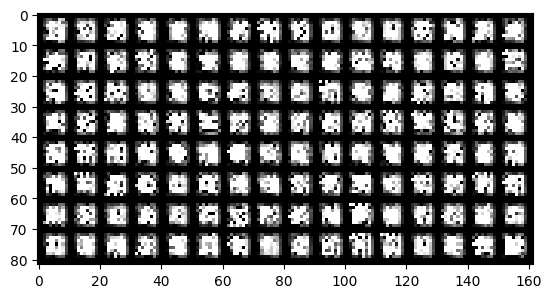

In [59]:
mu = posterior.mu
print(mu.shape)
for i in range(mu.shape[1]):
    plt.imshow(make_grid(mu[:,i][:,None,:,:], nrow=16).cpu().permute(1,2,0))
    plt.show()

In [60]:
z_c, z_s = mu.chunk(2, dim=1)
z_s = torch.cat([z_s[2:], z_s[:2]], dim=0)
z = torch.cat([z_c, z_s], dim=1).contiguous()
z.shape


torch.Size([128, 2, 8, 8])

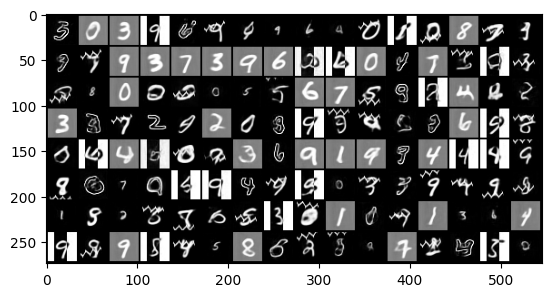

In [69]:
with torch.no_grad():
    best_model.eval()
    z = z * 0.18215
    x = best_model.decoder(z)
    plt.imshow(make_grid(x, nrow=16).cpu().permute(1,2,0))